# Nuage Compta et la facture s'analysa

## 0. Import des librairies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import keras
from keras import metrics
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation
import os
import pickle
import cv2
import imutils
from imutils.contours import sort_contours

from src import import_auto      ### Ma fonction == optimisation (voir import_auto.py) ###
from src import negatif_test     ### Ma fonction == passer l'image de mon choix en negatif ###

Using TensorFlow backend.


## 1. Optimisation et nettoyage des données

In [2]:
### Afin de réduire les temps d'attente et dans un soucis d'optimisation, je decide d'importer une fonction qui prend 200 png par lettres (suffisant ici). Ces images viennent s'ajouter au dossier dataset_reduit_train ###
import_auto.import_fichier_train()

In [3]:
### Afin de réduire les temps d'attente et dans un soucis d'optimisation, je decide d'importer une fonction qui prend 3 png par lettres (suffisant ici). Ces images viennent s'ajouter au dossier dataset_reduit_test ###
import_auto.import_fichier_test()

## 2. Import des Datasets

In [4]:
### ImageDataGenerator génère des lots de données d'image vectorielles, convertissant les coefficients RVB compris entre 0 et 255 en valeurs cibles comprises entre 0 et 1 par mise à l'échelle avec un facteur de 1/255 à l' aide de la remise à l' échelle ###

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    ### shear_range est utilisé pour appliquer de manière aléatoire des transformations de cisaillement ###
    shear_range = 0.2,
    ### zoom_range est utilisé pour zoomer aléatoirement à l'intérieur des images ###           
    zoom_range = 0.2,
    ### horizontal_flip est utilisé pour retourner au hasard la moitié des images horizontalement ###            
    horizontal_flip = True
)      

test_datagen = ImageDataGenerator(rescale = 1./255)


### J'importe les images une par une à partir des répertoires en utilisant .flow_from_directory et y appliquons ImageDataGenerator ###

train_generator = train_datagen.flow_from_directory(
    ### Choix de mon repertoire ###
    directory = "data/dataset_reduit_train",
    ### Je converti les images de leur taille d'origine à notre target_size ###                    
    target_size = (28,28),
    ### Nombre batch_size qui fait référence au nombre d'exemples d'entraînement utilisés dans une itération ###                                      
    batch_size = 32,
    ### Je definis le class_mode sur "catégorical" indiquant que nous avons plusieurs classes (a à z) à prédire ###          
    class_mode = "categorical",
    ### Je choisis le color_mode "grayscale", indiquant que nous trvaillons sur une image en noir et blanc
    color_mode = "grayscale"                                

)

test_generator = test_datagen.flow_from_directory(
    directory = "data/dataset_reduit_test",
    target_size = (28,28),
    batch_size = 32,
    class_mode = "categorical",
    color_mode = "grayscale"

)

Found 5207 images belonging to 27 classes.
Found 81 images belonging to 27 classes.


## 3. Definition du modèle d'architecture

In [5]:
### Création d'un modèle séquentiel qui permet de définir l'architecture CNN couche par couche à l'aide de la fonction .add .Nous ajoutons d'abord une couche de convolution avec 32 filtres de taille 3X3 sur les images d'entrée et la passons à travers la fonction d'activation 'relu'.Nous effectuons ensuite des opérations MaxPooling en utilisant un pool de taille 2X2 ###
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape = (28,28,1), activation = "relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))

### Ces couches sont ensuite répétées à nouveau pour améliorer les performances du modèle ###

model.add(Conv2D(32, (3, 3), activation = "relu"))
model.add(MaxPooling2D(pool_size = (2, 2)))

### Enfin, nous aplatissons notre matrice résultante et la passons à travers une couche dense composée de 128 nœuds. Celui-ci est ensuite connecté à la couche de sortie constituée de 26 nœuds, chaque nœud représentant un alphabet ###

model.add(Flatten())
model.add(Dense(units = 128, activation = "relu"))
model.add(Dense(units = 27, activation = "softmax"))            ### Activation softmax qui convertit les scores en une distribution de probabilité normalisée, et                                                                   le nœud avec la probabilité la plus élevée est sélectionné comme sortie ###

### Une fois notre architecture CNN définie, nous compilons le modèle à l'aide de l'optimiseur Adam ###
model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               102528    
_________________________________________________________________
dense_2 (Dense)              (None, 27)               

## 4. Entrainement du modèle

In [6]:
### Je décide de créer 30 répétitions, et j'ai X2 les steps_per_epoch pour augmenter notre précision ###

entrainement = model.fit_generator(
    train_generator,
    steps_per_epoch = 32,
    epochs = 30,
    validation_data = test_generator,
    validation_steps = 32
)

score = model.evaluate(train_generator, verbose=0)
print("Test de perte:", score[0])
print("Test de précision:", score[1])


Epoch 1/30
32/32 [==============================] - 2s 54ms/step - loss: 3.1317 - accuracy: 0.1113 - val_loss: 2.9598 - val_accuracy: 0.2963
Epoch 2/30
32/32 [==============================] - 2s 50ms/step - loss: 2.2013 - accuracy: 0.3750 - val_loss: 1.6803 - val_accuracy: 0.4226
Epoch 3/30
32/32 [==============================] - 2s 48ms/step - loss: 1.5293 - accuracy: 0.5241 - val_loss: 1.5238 - val_accuracy: 0.6054
Epoch 4/30
32/32 [==============================] - 2s 47ms/step - loss: 1.3524 - accuracy: 0.5713 - val_loss: 1.6890 - val_accuracy: 0.5904
Epoch 5/30
32/32 [==============================] - 2s 50ms/step - loss: 1.2221 - accuracy: 0.5957 - val_loss: 1.4140 - val_accuracy: 0.6892
Epoch 6/30
32/32 [==============================] - 2s 54ms/step - loss: 1.0575 - accuracy: 0.6533 - val_loss: 1.0772 - val_accuracy: 0.7078
Epoch 7/30
32/32 [==============================] - 2s 47ms/step - loss: 0.8949 - accuracy: 0.7051 - val_loss: 0.9560 - val_accuracy: 0.6545
Epoch 8/30
32

## 5. Enregistrement & chargement du modèle

In [7]:
### Enregistrement du modèle ###

pickle.dump(model, open("mon_model.h5", "wb"))

In [8]:
### Chargement du modèle ###

model = pickle.load(open("mon_model.h5","rb"))

## 6. Création d'une fonction qui renvois l'alphabet associé au résultat

In [9]:
def get_result(result):
    if result[0][0] == 1:
        return("a")
    elif result[0][1] == 1:
        return ("b")
    elif result[0][2] == 1:
        return ("c")
    elif result[0][3] == 1:
        return ("d")
    elif result[0][4] == 1:
        return ("e")
    elif result[0][5] == 1:
        return ("f")
    elif result[0][6] == 1:
        return ("g")
    elif result[0][7] == 1:
        return ("h")
    elif result[0][8] == 1:
        return ("i")
    elif result[0][9] == 1:
        return ("j")
    elif result[0][10] == 1:
        return ("k")
    elif result[0][11] == 1:
        return ("l")
    elif result[0][12] == 1:
        return ("m")
    elif result[0][13] == 1:
        return ("n")
    elif result[0][14] == 1:
        return ("o")
    elif result[0][15] == 1:
        return ("p")
    elif result[0][16] == 1:
        return ("q")
    elif result[0][17] == 1:
        return ("r")
    elif result[0][18] == 1:
        return ("s")
    elif result[0][19] == 1:
        return ("t")
    elif result[0][20] == 1:
        return ("u")
    elif result[0][21] == 1:
        return ("v")
    elif result[0][22] == 1:
        return ("w")
    elif result[0][23] == 1:
        return ("x")
    elif result[0][24] == 1:
        return ("y")
    elif result[0][25] == 1:
        return ("z")
    elif result[0][26] == 1:                # Création du symbole <3
        return ("<3")

## 7. Choix de l'image à envoyer & Test du modèle

La lettre correspondante est: <3


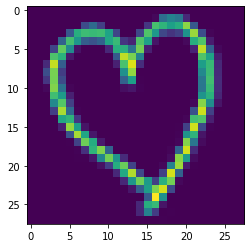

In [10]:
choix = r"assets\COEUR-thomas.png"
test_image = image.load_img(choix, target_size = (28,28), grayscale = True)
plt.imshow(test_image)
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
### TEST du <3 ###
resultat = model.predict(test_image)
resultat = get_result(resultat)
print(f"La lettre correspondante est: {resultat}")


## ZONE DE TEST

In [13]:
imagePath = 'assets\imagedentrainement.jpeg'

In [14]:
### Je charge mon image d'entrée à partir de la variable "imagePath" puis je la convertie en niveau de gris ###

image = cv2.imread(imagePath)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

blurred = cv2.medianBlur(gray,5)

In [15]:
### Détection des contours ###

blurred = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

edged = cv2.Canny(blurred, 170, 255)
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="left-to-right")[0]

### Initialisation de la liste des contours ###

chars = []

In [16]:
### Boucle sur les différents contours ###
for c in cnts:
    ### Calculer la boîte englobante du contour ###
    (x, y, w, h) = cv2.boundingRect(c)
    ### Je filtre les boîtes englobantes, en m'assurant qu'elles ne sont ni trop petites ni trop grandes ###
    if (w >= 5 and w <= 150) and (h >= 15 and h <= 120):
        ### On extrait le caractère pour faire en sorte qu'il apparaisse comme blanc sur fond noir, puis on saisie la largeur et la hauteur de l'image seuillée ###
        roi = gray[y:y + h, x:x + w]
        thresh = cv2.threshold(roi, 0, 255,
                               cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        (tH, tW) = thresh.shape
        ### Si la largeur est supérieure à la hauteur, on redimensionne la dimension de la largeur ###
        if tW > tH:
            thresh = imutils.resize(thresh, width=28)
        ### Sinon on redimensionne la longueur de la hauteur ###
        else:
            thresh = imutils.resize(thresh, height=28)

        ### On force les dimensions en 28 * 28 ###
        padded = cv2.copyMakeBorder(thresh, top=4, bottom=4,
                                    left=4, right=4, borderType=cv2.BORDER_CONSTANT,
                                    value=(0, 0, 0))
        
        padded = cv2.resize(padded, (28, 28))
        padded = padded.astype("float32") / 255.0
        padded = np.expand_dims(padded, axis=-1)
        ### Mise à jour notre liste de caractères qui seront OCR ###
        chars.append((padded, (x, y, w, h)))

In [17]:
### Extraction des emplacements de la boîte englobante et des caractères remplis ###
boxes = [b[1] for b in chars]
chars = np.array([c[0] for c in chars], dtype="float32")


### OCR les caractères à l'aide de notre modèle de reconnaissance de l'écriture manuscrite ###

preds = model.predict(chars)


In [18]:
### On définie la liste des noms des "étiquettes" (ABCDEFG...)
labelNames = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]

In [19]:
### Boucle sur les prédictions et les emplacements de la boîte englobante ensemble ###
for (pred, (x, y, w, h)) in zip(preds, boxes):
    ### trouver l'index de l'étiquette avec le plus grand correspondant probabilité, puis extrayez la probabilité et l'étiquette ###
    i = np.argmax(pred)
    prob = pred[i]
    label = labelNames[i]
    # Dessin de la prediction sur l'image ###
    print("[INFO] {} - {:.2f}%".format(label, prob * 100))
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(image, label, (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 2)

[INFO] F - 98.59%
[INFO] O - 50.33%
[INFO] R - 86.64%
[INFO] M - 99.50%
[INFO] A - 89.97%
[INFO] T - 98.79%
[INFO] S - 44.00%
[INFO] Q - 78.47%
[INFO] N - 91.50%
[INFO] D - 57.18%
[INFO] K - 39.10%
[INFO] T - 83.57%
[INFO] A - 75.27%
[INFO] X - 61.67%
[INFO] A - 83.08%


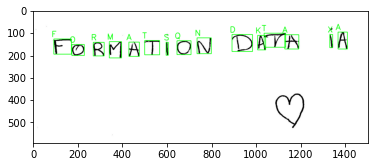

In [20]:
### Montre l'image ###
plt.imshow(image)
